In [1]:
import numpy as np
import random
# Importing standard Qiskit libraries
from qiskit import *
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_state_city
from ibm_quantum_widgets import *

In [2]:
#3-coloring vertex coloring problem using grover algorithm (np-problem in classical computer, still np in this algorithm but 
#improves the bruce-force algorithm by (theoretically) square-rooting numbers of iterations)

In [3]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model

In [4]:
#條誇號參數絕定其error
noise_model = get_noise(0.01)

In [5]:
def diffuser(n):
    qc = QuantumCircuit(n)
    for qubit in range(n):
        qc.h(qubit)
    for qubit in range(n):
        qc.x(qubit)
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)
    qc.h(n-1)
    
    for qubit in range(n):
        qc.x(qubit)
    for qubit in range(n):
        qc.h(qubit)
    
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [6]:
def vertexcolor_oracle(qc, v_list, e_list):
    #qc.x(in_qubits_v[3])
    #qc.x(in_qubits_v[4])
    #qc.x(in_qubits_v[7])


    for j in range(3*len(e_list)):
        qc.x(ax_qubits_e[j])
    for j in range(len(v_list)):
        qc.x(check4_qubits[j])

    #check two number are not same
    i = 0
    for e in e_list:
        qc.cx(in_qubits_v[2*e[0]], ax_qubits_e[i])
        qc.cx(in_qubits_v[2*e[1]], ax_qubits_e[i])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]+1], ax_qubits_e[i+1])
        qc.cx(in_qubits_v[2*e[1]+1], ax_qubits_e[i+1])
        qc.barrier()
        qc.ccx(ax_qubits_e[i], ax_qubits_e[i+1], ax_qubits_e[i+2])
        qc.barrier()
        i += 3


    #check the number is not 4
    for j in range(len(v_list)):
        qc.ccx(in_qubits_v[2*j], in_qubits_v[2*j+1], check4_qubits[j])
    qc.barrier()


    #target
    check_qubitslist = []
    for j in range(len(e_list)):
        check_qubitslist.append(ax_qubits_e[j*3+2])
    for j in range(len(v_list)):
        check_qubitslist.append(check4_qubits[j])
    qc.mct(check_qubitslist, target[0])
    qc.barrier()

    #reverse part

    #check the number is not 4
    for j in range(len(v_list)):
        qc.ccx(in_qubits_v[2*j], in_qubits_v[2*j+1], check4_qubits[j])
    qc.barrier()

    #check two number are not same
    e_list_r = e_list[::-1]
    i = 3*(len(e_list) - 1)
    for e in e_list_r:
        qc.ccx(ax_qubits_e[i], ax_qubits_e[i+1], ax_qubits_e[i+2])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]+1], ax_qubits_e[i+1])
        qc.cx(in_qubits_v[2*e[1]+1], ax_qubits_e[i+1])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]], ax_qubits_e[i])
        qc.cx(in_qubits_v[2*e[1]], ax_qubits_e[i])
        qc.barrier()
        i -= 3

    for j in range(3*len(e_list)):
        qc.x(ax_qubits_e[j])
    for j in range(len(v_list)):
        qc.x(check4_qubits[j])
    qc.barrier()

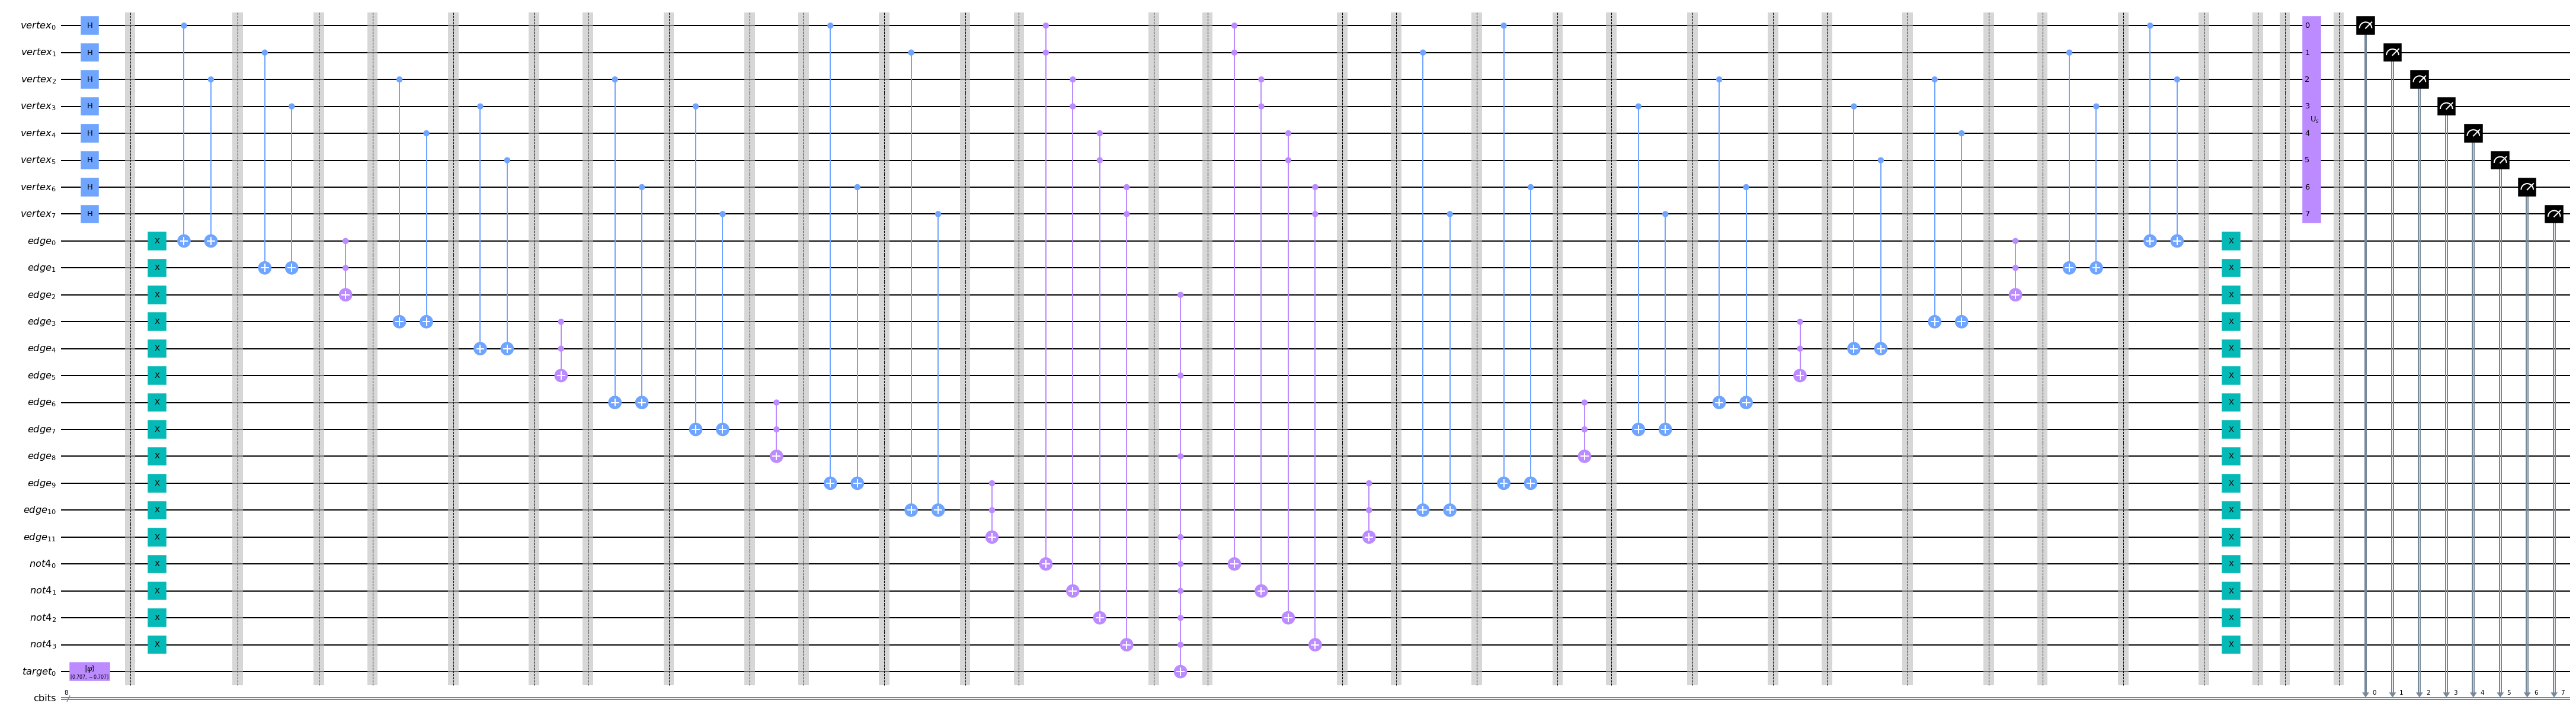

In [7]:
#example (v為vertex, e為edge)
# ex 1 
v_list = [0,1,2,3]
e_list = [[0,1],[1,2],[1,3], [0,3]]

#ex 2
#v_list = [0,1,2]
#e_list = [[0,1], [1,2]]

# choose n prob.
top_n = 14

#input vertex qubits
in_qubits_v = QuantumRegister(2*len(v_list), name = 'vertex')
#auxiliary qubits (edge)
ax_qubits_e = QuantumRegister(3*len(e_list), name = 'edge')
#因為這裡是做3-coloring，第四個顏色的答案要捨去
check4_qubits = QuantumRegister(len(v_list), name = 'not4')
#target qubit
target = QuantumRegister(1, name = 'target')
#cbit:輸出結果
cbits = ClassicalRegister(2*len(v_list), name = 'cbits')


qc = QuantumCircuit(in_qubits_v, ax_qubits_e, check4_qubits, target, cbits)

#initialize 'target' as |->
qc.initialize([1, -1]/np.sqrt(2), target)

#parallelization
qc.h(in_qubits_v)
qc.barrier()

#取的次數視情況而定，這裡取4
#xx = random.randint(1, 4)

xx = 1

for jj in range(xx):
    #oracle
    vertexcolor_oracle(qc, v_list, e_list)
    qc.barrier()

    #diffuser
    qc.append(diffuser(2*len(v_list)), list(range(2*len(v_list))))
    qc.barrier()

#可以自行決定要run幾次(每個例子都會有不一樣的最佳次數)


#measure
qc.measure(in_qubits_v, cbits)

qc.draw(output='mpl', fold = -1)

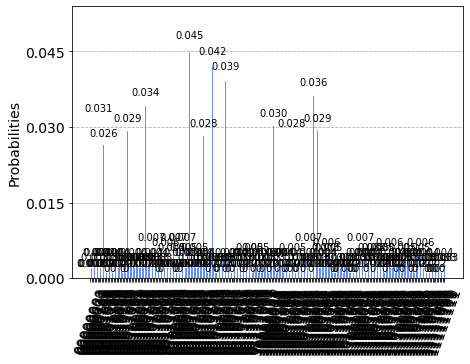

In [8]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
qobj = assemble(transpiled_qc)
result = qasm_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

[['01001000', 46], ['01011000', 43], ['01100010', 40], ['10100001', 37], ['00100110', 35], ['00000110', 32], ['10000100', 31], ['10100100', 30], ['00011001', 30], ['10010001', 29], ['01010010', 29], ['00001001', 27], ['10011110', 7], ['00111100', 7], ['01000011', 7], ['00101010', 7], ['11000011', 7], ['11010111', 6], ['10101011', 6], ['11101111', 6], ['00110110', 6], ['10101010', 5], ['01001011', 5], ['11101011', 5], ['11100001', 5], ['11001010', 5], ['00111010', 5], ['11001101', 5], ['01000100', 5], ['10101100', 5], ['10010010', 5], ['01110011', 5], ['01110111', 5], ['11010000', 5], ['11000111', 4], ['00001100', 4], ['01010000', 4], ['01000111', 4], ['10001001', 4], ['10101000', 4], ['01100111', 4], ['01001111', 4], ['11100100', 4], ['11101100', 4], ['11011010', 4], ['11110010', 4], ['11001001', 4], ['10001111', 4], ['00001101', 4], ['10011011', 4], ['10101001', 4], ['11100010', 4], ['01110010', 4], ['11100101', 4], ['11111100', 4], ['00010001', 4], ['00010010', 4], ['01111111', 4], [

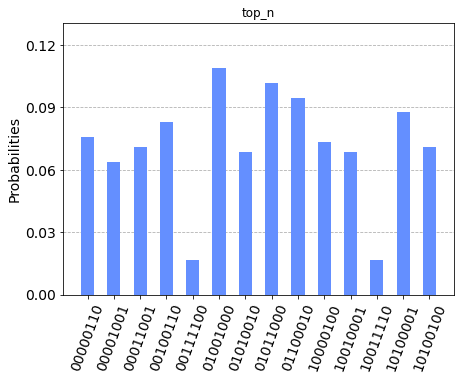

In [9]:
p1 = []
pause = result.get_counts()
pause.clear()
di = dict.fromkeys(counts)
for i in di.keys():
    p1.append([i,counts.get(i)])
p1.sort(key = lambda s: s[1],reverse = True)
print(p1)
for i in range(top_n):
        a = p1[i]
        pause.setdefault(a[0],a[1])
plot_histogram(pause, title="top_n",bar_labels = False)

In [10]:
print(counts)

{'10100000': 2, '00111101': 1, '00010011': 2, '00111110': 1, '11110011': 1, '00011000': 1, '11001000': 2, '10111011': 1, '01101011': 2, '10000001': 1, '11100110': 1, '11000001': 3, '10001100': 1, '00111001': 2, '01000010': 2, '10101010': 5, '11101001': 1, '11001011': 1, '00100011': 2, '01101101': 3, '01000110': 2, '10011010': 1, '00111000': 2, '10111111': 1, '10110111': 3, '10000110': 1, '11010110': 2, '00011011': 3, '10010000': 1, '01111011': 1, '11010100': 1, '00011111': 2, '01101001': 3, '11110101': 1, '00110111': 2, '11000111': 4, '00001111': 1, '11101000': 2, '10010111': 2, '01011011': 1, '10011110': 7, '01111001': 1, '10110011': 2, '10110000': 1, '00001100': 4, '11110100': 1, '01010000': 4, '10100101': 2, '01000001': 1, '01000111': 4, '11111000': 1, '11100111': 2, '01111110': 2, '00001011': 1, '10001001': 4, '01100011': 1, '00100010': 2, '10111100': 3, '10001101': 1, '01101111': 2, '11010111': 6, '01001011': 5, '00000000': 2, '10010001': 29, '00010100': 3, '01101110': 1, '1110001